In [92]:
!git clone https://github.com/FSMVU-Tubitak-1001-Kod-Analiz/Code_Similarity.git
%cd Code_Similarity
!ls


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cloning into 'Code_Similarity'...
remote: Enumerating objects: 1055, done.
remote: Counting objects: 100% (1052/1052), done.
remote: Compressing objects: 100% (244/244), done.
remote: Total 1055 (delta 394), reused 1007 (delta 352), pack-reused 3
Receiving objects: 100% (1055/1055), 1.20 MiB | 4.35 MiB/s, done.
Resolving deltas: 100% (394/394), done.
/home/user/PycharmProjects/code-similarity/code-similarity/Code_Similarity/Code_Similarity/Code_Similarity/Code_Similarity


/home/user/PycharmProjects/code-similarity/code-similarity/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'Dataset Triploss'	      Triplet_loss_code.ipynb   TripletLoss.py
 file_similarity_scores.csv   tripletloss.py


In [112]:
import os
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
import numpy as np
# Define the directory where the 'Dataset' folder is located
base_path = r'/home/user/PycharmProjects/code-similarity/code-similarity/Code_Similarity/Dataset Triploss'

# Arrays to hold the file paths
positive_array = []  # To store paths of 'plagiarized' files
anchor_array = []    # To store paths of 'original' files
negative_array = []  # To store paths of 'non-plagiarized' files

# Walk through the directory structure
for root, dirs, files in os.walk(base_path):
    for file in files:
        # Construct the full file path
        file_path = os.path.join(root, file)
        # Categorize the files based on the containing directory
        if 'plagiarized' in root:
            positive_array.append(file_path)
        if 'original' in root:
            anchor_array.append(file_path)
        if 'negative' in root:
            negative_array.append(file_path)


In [130]:
positive_array[0],anchor_array[0],negative_array[0]

('/home/user/PycharmProjects/code-similarity/code-similarity/Code_Similarity/Dataset Triploss/case-03/plagiarized/L1/01/L1.java',
 '/home/user/PycharmProjects/code-similarity/code-similarity/Code_Similarity/Dataset Triploss/case-03/original/T3.java',
 '/home/user/PycharmProjects/code-similarity/code-similarity/Code_Similarity/Dataset Triploss/case-03/negative/14/Soal3.java')

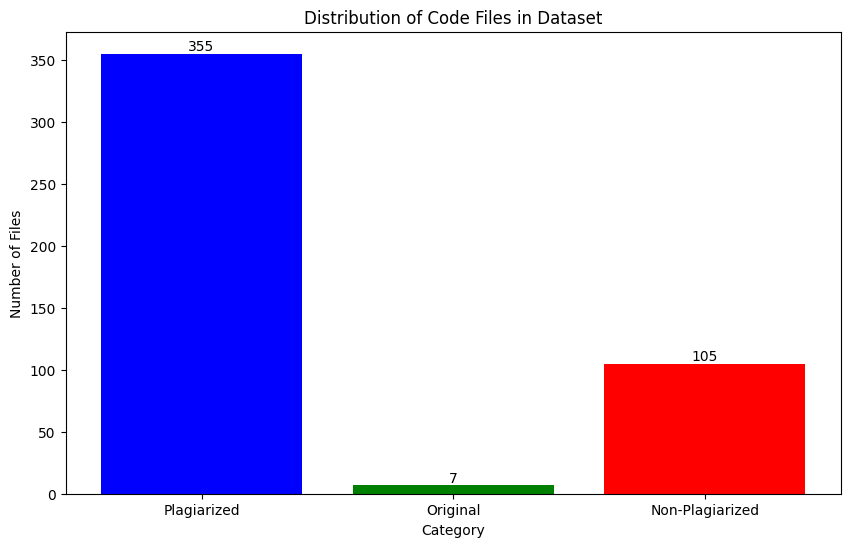

In [134]:
# For demonstration purposes, let's assume some example counts for each category
# Replace these with your actual counts
positive_count = len(positive_array) # Example count for plagiarized files
anchor_count = len(anchor_array)   # Example count for original files
negative_count = len(negative_array)  # Example count for non-plagiarized files

# Names of the categories
categories = ['Plagiarized', 'Original', 'Non-Plagiarized']

# Counts of each category
counts = [positive_count, anchor_count, negative_count]

# Creating the histogram
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, counts, color=['blue', 'green', 'red'])

# Adding the count above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.title('Distribution of Code Files in Dataset')
plt.xlabel('Category')
plt.ylabel('Number of Files')
plt.show()


In [135]:

# Gerekli Kütüphaneler
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
import os

# CodeBERT Tokenizer ve Modelini Yükle
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
codebert_model = TFAutoModel.from_pretrained("microsoft/codebert-base")
for layer in codebert_model.layers:
    if 'pooler' in layer.name:
        layer.trainable = False

# Kodu tokenize etme fonksiyonu
def tokenize_code(file_path, tokenizer):
    with open(file_path, 'r', encoding='utf-8') as file:
        code = file.read()
    inputs = tokenizer(code, return_tensors="tf", truncation=True, padding='max_length', max_length=512)
    return inputs['input_ids'], inputs['attention_mask']

# Dosyaları işleyip tokenize etme fonksiyonu
def load_and_tokenize_data(file_paths, tokenizer):
    input_ids_list = []
    attention_masks_list = []
    for path in file_paths:
        input_ids, attention_mask = tokenize_code(path, tokenizer)
        input_ids_list.append(tf.squeeze(input_ids))
        attention_masks_list.append(tf.squeeze(attention_mask))
    return input_ids_list, attention_masks_list

# Gömme Modelini Tanımla
def codebert_embedding_model():
    input_ids = tf.keras.layers.Input(shape=(512,), dtype='int32')
    attention_mask = tf.keras.layers.Input(shape=(512,), dtype='int32')
    embeddings = codebert_model(input_ids, attention_mask=attention_mask)[0][:,0,:]
    return tf.keras.Model(inputs=[input_ids, attention_mask], outputs=embeddings)

embedding_model = codebert_embedding_model()

# Triplet Loss Fonksiyonu

'''
Bu fonksiyon, modelin anchor ile positive arasındaki mesafeyi azaltıp,
 anchor ile negative arasındaki mesafeyi artırmasını sağlayacak şekilde kaybı (loss) hesaplar.
'''
def triplet_loss(y_true, y_pred, alpha=0.2):
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)  # Anchor ile Positive arasındaki mesafe
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)  # Anchor ile Negative arasındaki mesafe
    basic_loss = pos_dist - neg_dist + alpha  # Loss hesaplama
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0))  # Loss'un sıfırdan büyük olmasını sağlama
    return loss


# Veri setlerini yükle ve tokenize et
anchor_input_ids, anchor_attention_masks = load_and_tokenize_data(anchor_array, tokenizer)
positive_input_ids, positive_attention_masks = load_and_tokenize_data(positive_array, tokenizer)
negative_input_ids, negative_attention_masks = load_and_tokenize_data(negative_array, tokenizer)

# Veri setini oluştur
def create_dataset(input_ids, attention_masks):
    return tf.data.Dataset.from_tensor_slices((input_ids, attention_masks))

anchor_dataset = create_dataset(anchor_input_ids, anchor_attention_masks)
positive_dataset = create_dataset(positive_input_ids, positive_attention_masks)
negative_dataset = create_dataset(negative_input_ids, negative_attention_masks)

triplet_dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
batch_size = 32  # Batch boyutunu ayarla
triplet_dataset = triplet_dataset.batch(batch_size)

# Eğitim döngüsü
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
# Toplam eğitim epoch sayısını ayarla
num_epochs = 10

'''
Yukarıda verilen kod, bir Triplet Loss modelinin eğitimini ve modelin bir dosya olarak saklanmasını sağlar.
Eğitim sürecinde, model "code_similarity_model" adı altında yerel diskte kaydedilir.
Bu, modelin eğitim sonrası durumunu içerir ve bu modeli daha sonra kullanmak için bu dosyayı yükleyebilirsiniz.

'''
epoch_losses = []  # List to store epoch losses

# Eğitim epoch'ları için döngü
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1} başlıyor")  # Mevcut epoch'un başladığını bildir
    epoch_loss = 0  # Bu epoch için toplam kaybı sıfırla
    
    # Dataset üzerinden döngü yaparak her bir triplet için eğitim gerçekleştir
    for step, ((anchor_input, anchor_mask), (positive_input, positive_mask), (negative_input, negative_mask)) in enumerate(triplet_dataset):

        '''
        tf.GradientTape kullanımının nedeni, TensorFlow'da otomatik türev hesaplama işlevini sağlamasıdır.
        Derin öğrenme modelleri genellikle geri yayılım (backpropagation) yoluyla eğitilir,
        bu süreçte modelin ağırlıkları, kayıp fonksiyonunun (loss function) gradyanlarına göre güncellenir.
         tf.GradientTape bu gradyan hesaplamalarını kolaylaştırır.
        '''
        with tf.GradientTape() as tape:
            # Embedding modelini kullanarak anchor, positive ve negative için embedding'leri hesapla
            anchor_embeddings = embedding_model([anchor_input, anchor_mask])
            positive_embeddings = embedding_model([positive_input, positive_mask])
            negative_embeddings = embedding_model([negative_input, negative_mask])

            # Triplet kaybını hesapla
            loss = triplet_loss(None, [anchor_embeddings, positive_embeddings, negative_embeddings])

        # Hesaplanan kayıp üzerinden gradyanları hesapla
        gradients = tape.gradient(loss, embedding_model.trainable_variables)
        # Optimizer kullanarak gradyanları uygula ve model ağırlıklarını güncelle
        optimizer.apply_gradients(zip(gradients, embedding_model.trainable_variables))
        # Epoch kaybına bu adımdaki kaybı ekle
        epoch_loss += loss.numpy()
        epoch_losses.append(epoch_loss)  # Store the loss for this epoch

    # Epoch sonunda toplam kaybı yazdır
    print(f"Epoch {epoch+1} Kaybı: {epoch_loss}")


# Modeli kaydet
embedding_model.save("code_similarity_model")


# Modeli kaydetmek için dizin yolu oluşturun
saved_model_path = r"/home/user/PycharmProjects/code-similarity/code-similarity/Code_Similarity/Model"  # Burada istediğiniz bir yolu belirleyin
if not os.path.exists(saved_model_path):
    os.makedirs(saved_model_path)

# Modeli SavedModel formatında kaydedin
tf.saved_model.save(embedding_model, saved_model_path)

print(f"Model {saved_model_path} dizinine kaydedildi.")


All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at microsoft/codebert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1 başlıyor


Epoch 1 Kaybı: 1.1354544162750244
Epoch 2 başlıyor


Epoch 2 Kaybı: 0.0901002436876297
Epoch 3 başlıyor


Epoch 3 Kaybı: 0.05932176858186722
Epoch 4 başlıyor


Epoch 4 Kaybı: 0.0
Epoch 5 başlıyor


Epoch 5 Kaybı: 0.19573140144348145
Epoch 6 başlıyor


Epoch 6 Kaybı: 0.0
Epoch 7 başlıyor


Epoch 7 Kaybı: 0.0
Epoch 8 başlıyor


Epoch 8 Kaybı: 0.0
Epoch 9 başlıyor


Epoch 9 Kaybı: 0.0
Epoch 10 başlıyor


Epoch 10 Kaybı: 0.0


INFO:tensorflow:Assets written to: code_similarity_model/assets


INFO:tensorflow:Assets written to: code_similarity_model/assets


INFO:tensorflow:Assets written to: /home/user/PycharmProjects/code-similarity/code-similarity/Code_Similarity/Model/assets


INFO:tensorflow:Assets written to: /home/user/PycharmProjects/code-similarity/code-similarity/Code_Similarity/Model/assets


Model /home/user/PycharmProjects/code-similarity/code-similarity/Code_Similarity/Model dizinine kaydedildi.


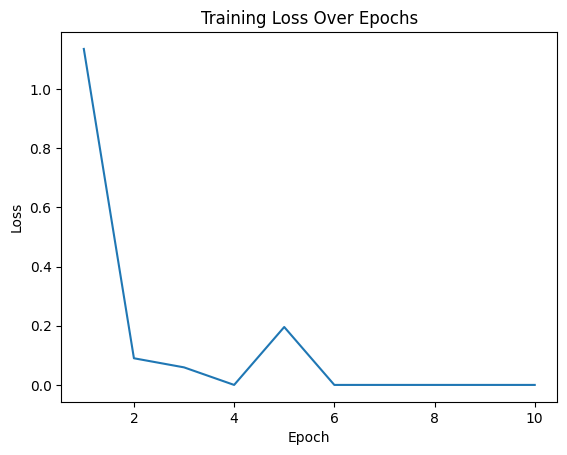

In [136]:
plt.plot(range(1, num_epochs + 1), epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

In [115]:
embedding_model.save_weights('mcode_similarity_model_weights.h5')

In [116]:
embedding_model.load_weights('mcode_similarity_model_weights.h5')

In [117]:

import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer

# Load CodeBERT Model
codebert_model = TFAutoModel.from_pretrained("microsoft/codebert-base")

# Rebuild the embedding model architecture (matching the saved model)
def codebert_embedding_model():
    input_ids = tf.keras.layers.Input(shape=(512,), dtype='int32')
    attention_mask = tf.keras.layers.Input(shape=(512,), dtype='int32')
    embeddings = codebert_model(input_ids, attention_mask=attention_mask)[0][:,0,:]
    return tf.keras.Model(inputs=[input_ids, attention_mask], outputs=embeddings)

# Instantiate the model
embedding_model = codebert_embedding_model()

# Load the weights from the saved model

embedding_model.load_weights('mcode_similarity_model_weights.h5')
# Triplet Loss Fonksiyonu

'''
Bu fonksiyon, modelin anchor ile positive arasındaki mesafeyi azaltıp,
 anchor ile negative arasındaki mesafeyi artırmasını sağlayacak şekilde kaybı (loss) hesaplar.
'''
def triplet_loss(y_true, y_pred, alpha=0.2):
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)  # Anchor ile Positive arasındaki mesafe
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)  # Anchor ile Negative arasındaki mesafe
    basic_loss = pos_dist - neg_dist + alpha  # Loss hesaplama
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0))  # Loss'un sıfırdan büyük olmasını sağlama
    return loss


# Veri setlerini yükle ve tokenize et
anchor_input_ids, anchor_attention_masks = load_and_tokenize_data(anchor_array, tokenizer)
positive_input_ids, positive_attention_masks = load_and_tokenize_data(positive_array, tokenizer)
negative_input_ids, negative_attention_masks = load_and_tokenize_data(negative_array, tokenizer)

# Veri setini oluştur
def create_dataset(input_ids, attention_masks):
    return tf.data.Dataset.from_tensor_slices((input_ids, attention_masks))

anchor_dataset = create_dataset(anchor_input_ids, anchor_attention_masks)
positive_dataset = create_dataset(positive_input_ids, positive_attention_masks)
negative_dataset = create_dataset(negative_input_ids, negative_attention_masks)

triplet_dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
batch_size = 32  # Batch boyutunu ayarla
triplet_dataset = triplet_dataset.batch(batch_size)

# Eğitim döngüsü
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
# Toplam eğitim epoch sayısını ayarla
num_epochs = 10

# Eğitim epoch'ları için döngü
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1} başlıyor")  # Mevcut epoch'un başladığını bildir
    epoch_loss = 0  # Bu epoch için toplam kaybı sıfırla

    # Dataset üzerinden döngü yaparak her bir triplet için eğitim gerçekleştir
    for step, ((anchor_input, anchor_mask), (positive_input, positive_mask), (negative_input, negative_mask)) in enumerate(triplet_dataset):

        with tf.GradientTape() as tape:
            # Embedding modelini kullanarak anchor, positive ve negative için embedding'leri hesapla
            anchor_embeddings = embedding_model([anchor_input, anchor_mask])
            positive_embeddings = embedding_model([positive_input, positive_mask])
            negative_embeddings = embedding_model([negative_input, negative_mask])

            # Triplet kaybını hesapla
            loss = triplet_loss(None, [anchor_embeddings, positive_embeddings, negative_embeddings])

        # Hesaplanan kayıp üzerinden gradyanları hesapla
        gradients = tape.gradient(loss, embedding_model.trainable_variables)
        # Optimizer kullanarak gradyanları uygula ve model ağırlıklarını güncelle
        optimizer.apply_gradients(zip(gradients, embedding_model.trainable_variables))
        # Epoch kaybına bu adımdaki kaybı ekle
        epoch_loss += loss.numpy()

    # Epoch sonunda toplam kaybı yazdır
    print(f"Epoch {epoch+1} Kaybı: {epoch_loss}")


# Modeli kaydet
embedding_model.save("new_code_similarity_model")


All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at microsoft/codebert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1 başlıyor


Epoch 1 Kaybı: 0.0
Epoch 2 başlıyor


Epoch 2 Kaybı: 0.0
Epoch 3 başlıyor


Epoch 3 Kaybı: 0.0
Epoch 4 başlıyor


Epoch 4 Kaybı: 0.0
Epoch 5 başlıyor


Epoch 5 Kaybı: 0.0
Epoch 6 başlıyor


Epoch 6 Kaybı: 0.0
Epoch 7 başlıyor


Epoch 7 Kaybı: 0.0
Epoch 8 başlıyor


Epoch 8 Kaybı: 0.0
Epoch 9 başlıyor


Epoch 9 Kaybı: 0.0
Epoch 10 başlıyor


Epoch 10 Kaybı: 0.0


INFO:tensorflow:Assets written to: new_code_similarity_model/assets


INFO:tensorflow:Assets written to: new_code_similarity_model/assets


In [118]:
all_arrays = np.concatenate((positive_array, anchor_array, negative_array), axis=0)

In [119]:
len(all_arrays)

467

In [124]:
all_arrays[0]

'/home/user/PycharmProjects/code-similarity/code-similarity/Code_Similarity/Dataset Triploss/case-03/plagiarized/L1/01/L1.java'

In [120]:
embedding_model.save_weights('new_mcode_similarity_model_weights.h5')

In [121]:
# Rebuild the embedding model architecture (matching the saved model)
def codebert_embedding_model():
    input_ids = tf.keras.layers.Input(shape=(512,), dtype='int32')
    attention_mask = tf.keras.layers.Input(shape=(512,), dtype='int32')
    embeddings = codebert_model(input_ids, attention_mask=attention_mask)[0][:,0,:]
    return tf.keras.Model(inputs=[input_ids, attention_mask], outputs=embeddings)

# Instantiate the model
embedding_model = codebert_embedding_model()

# Load the weights from the saved model
embedding_model.load_weights("new_mcode_similarity_model_weights.h5")

def get_embeddings(file_paths, tokenizer, embedding_model):
    embeddings = []
    for path in file_paths:
        input_ids, attention_mask = tokenize_code(path, tokenizer)  
        embedding = embedding_model.predict([input_ids, attention_mask])
        embeddings.append(embedding)
    return np.array(embeddings)

file_embeddings = get_embeddings(all_arrays, tokenizer, embedding_model)

1/1 [==============================] - 0s 386ms/step


In [137]:
file_embeddings

array([[[-0.14163618,  0.09809396,  0.00482307, ..., -0.05911174,
         -0.5362416 ,  0.5404009 ]],

       [[-0.12784305,  0.07232494,  0.00668415, ..., -0.12009836,
         -0.5672197 ,  0.51583123]],

       [[-0.15808322,  0.09880828,  0.03295183, ..., -0.09101688,
         -0.5153878 ,  0.52900887]],

       ...,

       [[-0.11016048,  0.02217015, -0.00234284, ..., -0.07208943,
         -0.5958338 ,  0.5298103 ]],

       [[-0.16940765, -0.02671118, -0.01802878, ..., -0.07803576,
         -0.57609975,  0.4933287 ]],

       [[-0.15300442, -0.00710349, -0.00725231, ..., -0.03707576,
         -0.5625479 ,  0.5090958 ]]], dtype=float32)

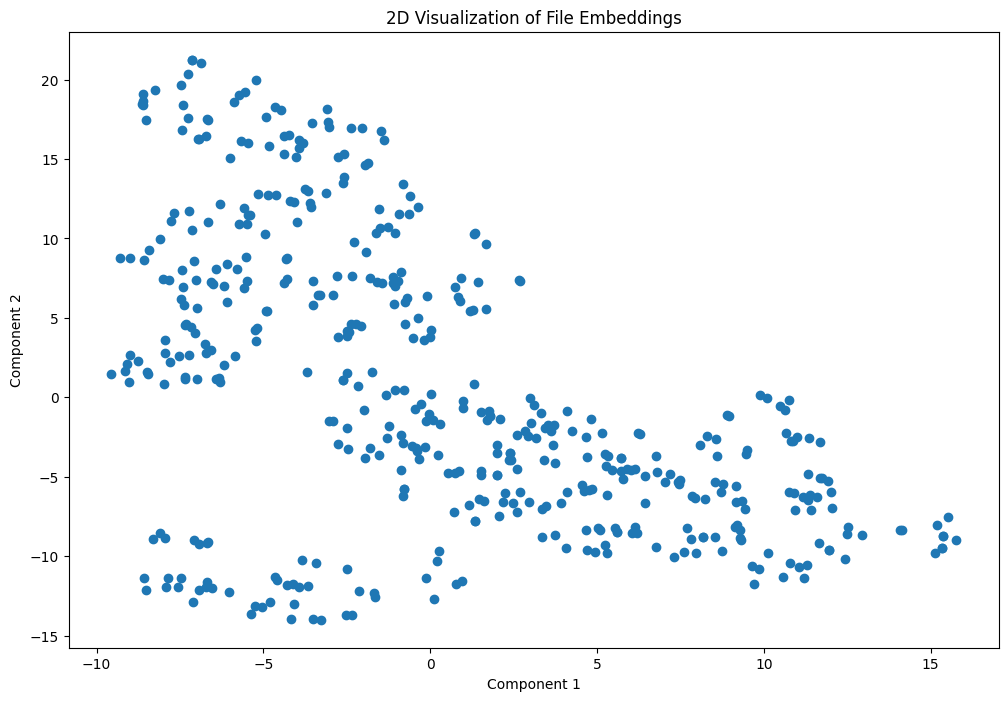

In [140]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Since file_embeddings would be a list of np.arrays, we need to stack them into one array
file_embeddings_stacked = np.vstack(file_embeddings)

# Use t-SNE to reduce dimensionality to 2D for plotting
tsne = TSNE(n_components=3, random_state=42)
file_embeddings_2d = tsne.fit_transform(file_embeddings_stacked)

# Plot the 2D embeddings
plt.figure(figsize=(12,8))
plt.scatter(file_embeddings_2d[:, 0], file_embeddings_2d[:, 1])
plt.title('2D Visualization of File Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import AutoTokenizer

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

# Rebuild the model
def codebert_embedding_model():
    input_ids = tf.keras.layers.Input(shape=(512,), dtype='int32')
    attention_mask = tf.keras.layers.Input(shape=(512,), dtype='int32')
    embeddings = codebert_model(input_ids, attention_mask=attention_mask)[0][:,0,:]
    return tf.keras.Model(inputs=[input_ids, attention_mask], outputs=embeddings)

embedding_model = codebert_embedding_model()
embedding_model.load_weights("new_mcode_similarity_model_weights.h5")

# Tokenize and Embedding Generation Function
def tokenize_code(file_path, tokenizer):
    with open(file_path, 'r', encoding='utf-8') as file:
        code = file.read()
    inputs = tokenizer(code, return_tensors="tf", truncation=True, padding='max_length', max_length=512)
    return tf.squeeze(inputs['input_ids']), tf.squeeze(inputs['attention_mask'])

def generate_embedding(file_path, tokenizer, model):
    input_ids, attention_mask = tokenize_code(file_path, tokenizer)
    embedding = model([tf.expand_dims(input_ids, 0), tf.expand_dims(attention_mask, 0)])
    return embedding[0]

# Generate embeddings for all files
file_embeddings = {file: generate_embedding(file, tokenizer, embedding_model) for file in all_arrays}

# Custom Similarity Function
def custom_similarity(embedding1, embedding2):
    distance = tf.norm(embedding1 - embedding2)
    similarity = tf.exp(-distance)
    return similarity.numpy()

# Prepare pairs for comparison and calculate similarity
comparisons = []
for i in range(len(all_arrays)):
    for j in range(i+1, len(all_arrays)):
        file1, file2 = all_arrays[i], all_arrays[j]
        similarity_score = custom_similarity(file_embeddings[file1], file_embeddings[file2])
        comparisons.append([file1, file2, similarity_score])

# Create DataFrame
df = pd.DataFrame(comparisons, columns=['file1', 'file2', 'similarity'])

# Display or save the DataFrame
print(df.head())
# df.to_csv('file_similarity_scores.csv', index=False)


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import AutoTokenizer

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

# Assuming the functions codebert_embedding_model, tokenize_code, and generate_embedding are defined as before

embedding_model = codebert_embedding_model()
embedding_model.load_weights("new_mcode_similarity_model_weights.h5")


# Generate embeddings for all files
file_embeddings = {file: generate_embedding(file, tokenizer, embedding_model) for file in all_arrays}

# Custom Similarity Function
def custom_similarity(embedding1, embedding2):
    distance = tf.norm(embedding1 - embedding2)
    similarity = tf.exp(-distance)
    return similarity.numpy()

# Define a threshold for similarity
similarity_threshold = 0.5  # You may need to adjust this value

# Prepare pairs for comparison, calculate similarity, and label
comparisons = []
for i in range(len(all_arrays)):
    for j in range(i+1, len(all_arrays)):
        file1, file2 = all_arrays[i], all_arrays[j]
        similarity_score = custom_similarity(file_embeddings[file1], file_embeddings[file2])
        label = "yes" if similarity_score >= similarity_threshold else "no"
        comparisons.append([file1, file2, label])

# Create DataFrame
df = pd.DataFrame(comparisons, columns=['file1', 'file2', 'label'])

# Display or save the DataFrame
print(df.head())
# df.to_csv('file_similarity_labels.csv', index=False)


In [ ]:
df.to_csv('file_similarity_dataset.csv', index=False)  # To save to a CSV file

In [150]:
print(df.head(1))

                                               file1  \
0  /home/user/PycharmProjects/code-similarity/cod...   

                                               file2 label  
0  /home/user/PycharmProjects/code-similarity/cod...    no  


In [125]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import GRU, Dense, Input, Concatenate
from tensorflow.keras.models import Model
embedding_model = codebert_embedding_model()
embedding_model.load_weights("new_mcode_similarity_model_weights.h5")
# Generate embeddings for each file
#file_embeddings = get_embeddings(all_arrays, tokenizer, embedding_model)

# Prepare pairs of embeddings and labels for GRU
def prepare_pairs_and_labels(df, embeddings):
    pairs = []
    labels = []
    for _, row in df.iterrows():
        file1_index = np.where(all_arrays == row['file1'])[0][0]
        file2_index = np.where(all_arrays == row['file2'])[0][0]
        pairs.append(np.concatenate([embeddings[file1_index], embeddings[file2_index]]))
        labels.append(1 if row['label'] == 'yes' else 0)
    return np.array(pairs), np.array(labels)

pairs, labels = prepare_pairs_and_labels(df, file_embeddings)

# Split the data into training and test sets
train_pairs, test_pairs, train_labels, test_labels = train_test_split(pairs, labels, test_size=0.2, random_state=42)



In [126]:
train_pairs

array([[[-1.21589109e-01,  1.28530106e-02, -3.38866711e-02, ...,
         -3.04514468e-02, -6.07127786e-01,  5.62189639e-01],
        [-1.51905447e-01,  5.58534749e-02,  4.51145880e-02, ...,
         -7.75929466e-02, -5.33326745e-01,  4.63465035e-01]],

       [[-1.60097748e-01,  3.65802273e-03, -5.70366196e-02, ...,
         -8.92864540e-02, -5.53961277e-01,  4.93913382e-01],
        [-1.47676274e-01, -3.36678363e-02, -4.36971411e-02, ...,
         -1.07287005e-01, -6.00591600e-01,  4.52217579e-01]],

       [[-8.50146860e-02,  2.63041295e-02, -4.91912887e-02, ...,
         -1.78905278e-02, -5.55695891e-01,  4.77093816e-01],
        [-1.23309217e-01,  7.81061426e-02,  3.29925679e-02, ...,
         -4.72574532e-02, -5.66953540e-01,  5.34310162e-01]],

       ...,

       [[-1.14190742e-01,  3.52792740e-02,  4.34295721e-02, ...,
         -3.93711627e-02, -5.73682904e-01,  5.40191948e-01],
        [-9.79688913e-02,  2.48303618e-02,  3.11865658e-02, ...,
          2.22712606e-02, -6.09623

In [142]:
# Define GRU model
def build_gru_model(input_shape):
    input_layer = Input(shape=input_shape)
    gru_layer = GRU(64, return_sequences=False)(input_layer)
    output_layer = Dense(1, activation='sigmoid')(gru_layer)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

gru_model = build_gru_model(train_pairs.shape[1:])  # Adjust input shape as necessary

# Train the model
history = gru_model.fit(train_pairs, train_labels, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
evaluation = gru_model.evaluate(test_pairs, test_labels)
print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")


Epoch 1/10
2177/2177 [==============================] - 14s 6ms/step - loss: 0.0271 - accuracy: 0.9954 - val_loss: 0.0249 - val_accuracy: 0.9961
Epoch 2/10
2177/2177 [==============================] - 12s 5ms/step - loss: 0.0253 - accuracy: 0.9959 - val_loss: 0.0257 - val_accuracy: 0.9961
Epoch 3/10
2177/2177 [==============================] - 12s 5ms/step - loss: 0.0242 - accuracy: 0.9959 - val_loss: 0.0232 - val_accuracy: 0.9961
Epoch 4/10
2177/2177 [==============================] - 12s 5ms/step - loss: 0.0239 - accuracy: 0.9959 - val_loss: 0.0228 - val_accuracy: 0.9961
Epoch 5/10
2177/2177 [==============================] - 12s 5ms/step - loss: 0.0235 - accuracy: 0.9959 - val_loss: 0.0227 - val_accuracy: 0.9961
Epoch 6/10
2177/2177 [==============================] - 12s 5ms/step - loss: 0.0230 - accuracy: 0.9959 - val_loss: 0.0220 - val_accuracy: 0.9961
Epoch 7/10
2177/2177 [==============================] - 12s 5ms/step - loss: 0.0226 - accuracy: 0.9959 - val_loss: 0.0218 - val_ac

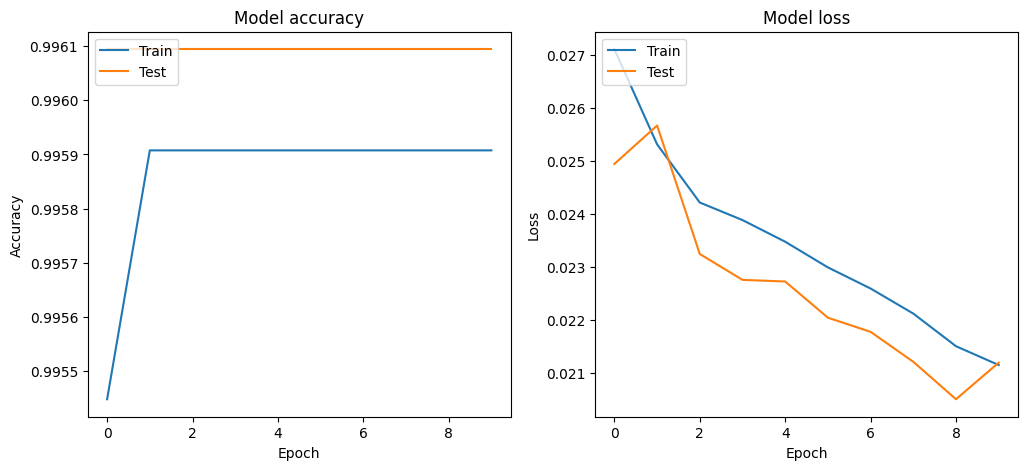

In [143]:
# Plot the training history
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

681/681 [==============================] - 2s 2ms/step


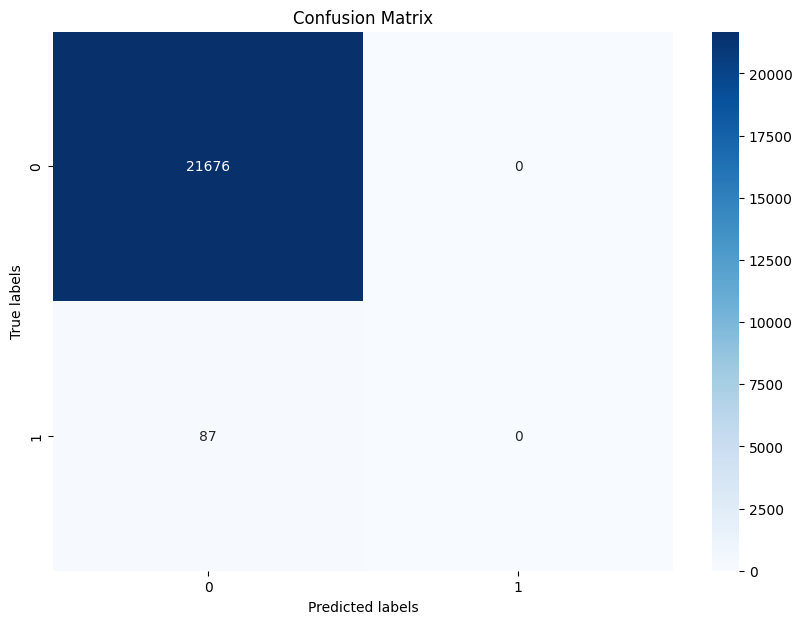

In [145]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate predictions
test_predictions = gru_model.predict(test_pairs)
# If your model outputs probabilities, you may want to convert these to binary predictions
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions_binary)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [161]:
import os

def generate_embedding(file_path, tokenizer, embedding_model):
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None
    
    # Read the file content
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            code = file.read()
    except Exception as e:
        print(f"An error occurred while reading file {file_path}: {e}")
        return None
    
    # Tokenize the code
    inputs = tokenizer(code, return_tensors="tf", max_length=512, truncation=True, padding='max_length')
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    
    # Generate the embedding
    embeddings = embedding_model.predict([input_ids, attention_mask])  # Using .predict() for inference
    
    # Check the dimensions of the output and adjust accordingly
    if len(embeddings.shape) == 2:
        # The embeddings are already 2D, so we can return them directly
        return embeddings
    elif len(embeddings.shape) == 3:
        # If the output is 3D, we take the first token's embedding
        return embeddings[:, 0, :]
    else:
        raise ValueError(f"Unexpected shape for embeddings: {embeddings.shape}")

# Generate embeddings for all files
file_embeddings = {file: generate_embedding(file, tokenizer, embedding_model) for file in all_arrays}


1/1 [==============================] - 1s 501ms/step


In [175]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import AutoTokenizer

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

# Assuming the functions codebert_embedding_model, tokenize_code, and generate_embedding are defined as before

embedding_model = codebert_embedding_model()

# Custom Similarity Function
def custom_similarity(embedding1, embedding2):
    distance = tf.norm(embedding1 - embedding2)
    similarity = tf.exp(-distance)
    return similarity.numpy()

# Define a threshold for similarity
similarity_threshold = 0.2  # You may need to adjust this value

# Prepare pairs for comparison, calculate similarity, and label
comparisons = []
for i in range(len(all_arrays)):
    for j in range(i+1, len(all_arrays)):
        file1, file2 = all_arrays[i], all_arrays[j]
        similarity_score = custom_similarity(file_embeddings[file1], file_embeddings[file2])
        print(similarity_score)
        label = "yes" if similarity_score >= similarity_threshold else "no"
        comparisons.append([file1, file2, label])

# Create DataFrame
df = pd.DataFrame(comparisons, columns=['file1', 'file2', 'label'])

# Display or save the DataFrame
print(df.head())
# df.to_csv('file_similarity_labels.csv', index=False)


0.118908726
0.3219471
0.18637341
0.11966603
0.49840862
0.40975514
0.10212606
0.43942365
0.104215354
0.10067019
0.10668088
0.14314696
0.36595577
0.3860464
0.091030024
0.17932512
0.096912116
0.14739946
0.08892689
0.08082241
0.13222596
0.059262406
0.08035996
0.17152669
0.19093269
0.08933209
0.14739946
0.08892689
0.08781548
0.14351286
0.06439189
0.10070915
0.17638996
0.39717466
0.106383555
0.30865043
0.10210011
0.08692385
0.37456283
0.15279408
0.16334945
0.34941688
0.21332584
0.08883395
0.15300092
0.08892689
0.07987288
0.16991583
0.039735544
0.088399515
0.17638996
0.1893616
0.12408968
0.14522806
0.105362445
0.116829805
0.18536636
0.0274828
0.06840554
0.08359403
0.12707955
0.06783402
0.15540706
0.071960695
0.087967314
0.19733635
0.029275175
0.073074184
0.10342422
0.11959131
0.0909965
0.19791795
0.0687247
0.06919426
0.08375856
0.029148176
0.056295335
0.056093857
0.138893
0.10565573
0.19077256
0.06862097
0.13200954
0.1440532
0.038522992
0.050522942
0.08617855
0.21423058
0.12155375
0.15811266


In [176]:
df.to_csv('code_bert_file_similarity_labels.csv', index=False)

In [177]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import GRU, Dense, Input, Concatenate
from tensorflow.keras.models import Model
embedding_model = codebert_embedding_model()
# Generate embeddings for each file
# Rebuild the embedding model architecture (matching the saved model)
def codebert_embedding_model():
    input_ids = tf.keras.layers.Input(shape=(512,), dtype='int32')
    attention_mask = tf.keras.layers.Input(shape=(512,), dtype='int32')
    embeddings = codebert_model(input_ids, attention_mask=attention_mask)[0][:,0,:]
    return tf.keras.Model(inputs=[input_ids, attention_mask], outputs=embeddings)

# Instantiate the model
embedding_model = codebert_embedding_model()


# Prepare pairs of embeddings and labels for GRU
def prepare_pairs_and_labels(df, embeddings):
    pairs = []
    labels = []
    for _, row in df.iterrows():
        file1_embedding = embeddings[row['file1']]
        file2_embedding = embeddings[row['file2']]
        pairs.append(np.concatenate([file1_embedding, file2_embedding]))
        labels.append(1 if row['label'] == 'yes' else 0)
    return np.array(pairs), np.array(labels)

pairs, labels = prepare_pairs_and_labels(df, file_embeddings)


# Split the data into training and test sets
train_pairs, test_pairs, train_labels, test_labels = train_test_split(pairs, labels, test_size=0.2, random_state=42)



In [178]:
# Define GRU model
def build_gru_model(input_shape):
    input_layer = Input(shape=input_shape)
    gru_layer = GRU(64, return_sequences=False)(input_layer)
    output_layer = Dense(1, activation='sigmoid')(gru_layer)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

gru_model = build_gru_model(train_pairs.shape[1:])  # Adjust input shape as necessary

# Train the model
history = gru_model.fit(train_pairs, train_labels, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
evaluation = gru_model.evaluate(test_pairs, test_labels)
print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")


Epoch 1/10
2177/2177 [==============================] - 14s 6ms/step - loss: 0.2948 - accuracy: 0.8778 - val_loss: 0.1921 - val_accuracy: 0.9158
Epoch 2/10
2177/2177 [==============================] - 12s 5ms/step - loss: 0.1715 - accuracy: 0.9245 - val_loss: 0.1530 - val_accuracy: 0.9356
Epoch 3/10
2177/2177 [==============================] - 12s 5ms/step - loss: 0.1461 - accuracy: 0.9362 - val_loss: 0.1600 - val_accuracy: 0.9275
Epoch 4/10
2177/2177 [==============================] - 12s 5ms/step - loss: 0.1299 - accuracy: 0.9435 - val_loss: 0.1111 - val_accuracy: 0.9508
Epoch 5/10
2177/2177 [==============================] - 12s 5ms/step - loss: 0.1213 - accuracy: 0.9483 - val_loss: 0.1228 - val_accuracy: 0.9477
Epoch 6/10
2177/2177 [==============================] - 12s 5ms/step - loss: 0.1165 - accuracy: 0.9503 - val_loss: 0.1379 - val_accuracy: 0.9369
Epoch 7/10
2177/2177 [==============================] - 12s 5ms/step - loss: 0.1122 - accuracy: 0.9518 - val_loss: 0.1181 - val_ac

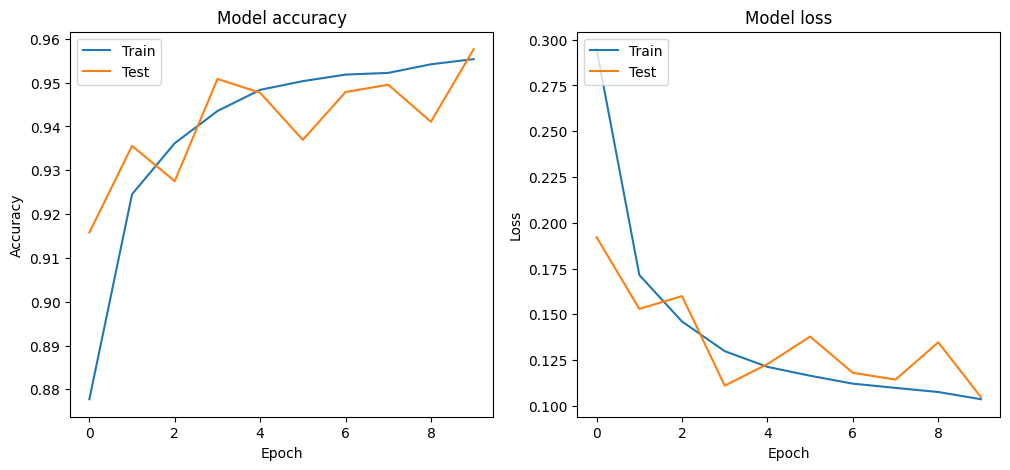

In [179]:
# Plot the training history
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()